##### Custom VQE

https://learning.quantum.ibm.com/course/variational-algorithm-design/examples-and-applications

##### VQE Qiskit

https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

In [101]:
import os
import csv
import time
import warnings
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from qiskit_algorithms import VQE
from scipy.optimize import minimize
from qiskit_aer.noise import NoiseModel
from qiskit_nature.units import DistanceUnit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

Setup

In [102]:
warnings.filterwarnings("ignore")
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_osaka'

Map classical inputs to a quantum problem

In [103]:
h1_a = np.array([[-0.5, 0          ],
                 [ 0         , -0.125]])

size = len(h1_a)

h2_aa = np.zeros((size, size, size, size))

h1_b = h1_a
h2_bb = h2_aa

h2_ba = h2_aa

hamiltonian = ElectronicEnergy.from_raw_integrals(h1_a, h2_aa, h1_b, h2_bb, h2_ba)

In [104]:
mapper = JordanWignerMapper()

fermionic_op = hamiltonian.second_q_op()
qubit_op = mapper.map(fermionic_op)

In [105]:
qubit_op

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII'],
              coeffs=[-0.625 +0.j,  0.25  +0.j,  0.0625+0.j,  0.25  +0.j,  0.0625+0.j])

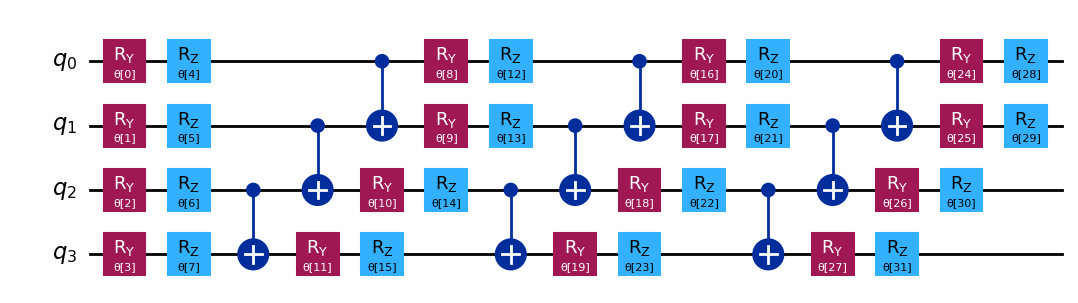

In [106]:
ansatz = EfficientSU2(qubit_op.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [107]:
num_params = ansatz.num_parameters
num_params

32

Optimize problem for quantum execution

In [110]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

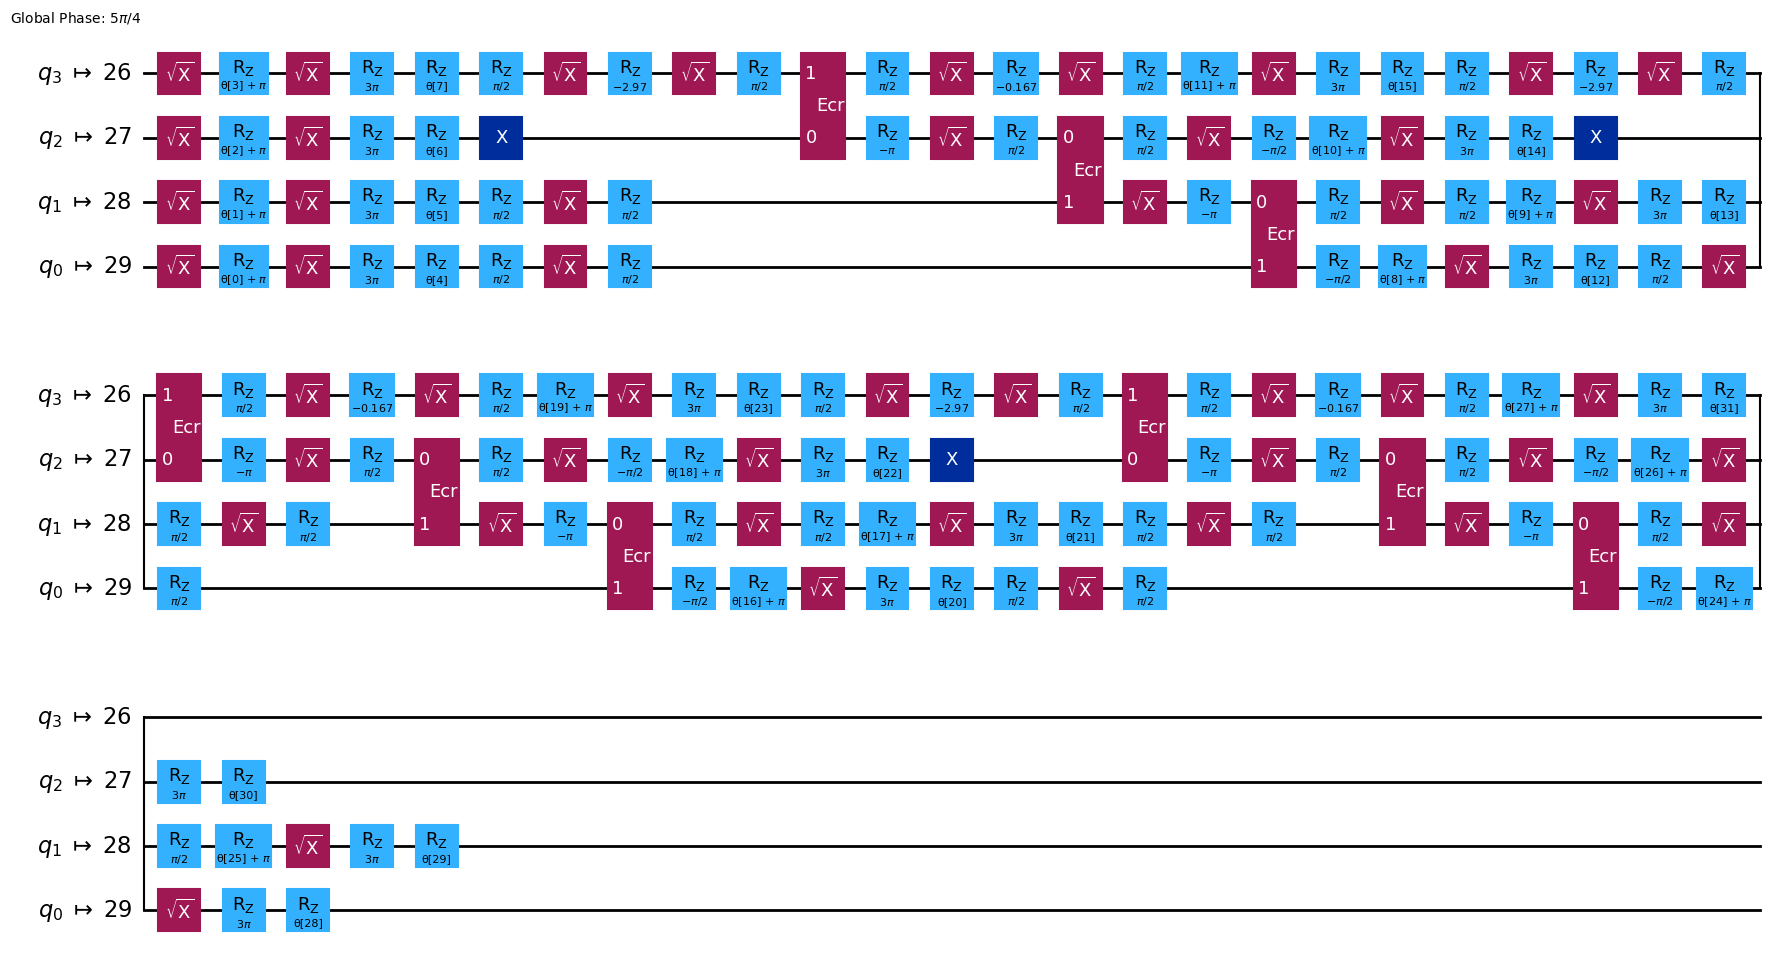

In [111]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [112]:
hamiltonian_isa = qubit_op.apply_layout(layout=ansatz_isa.layout)

Execute using Qiskit Primitives

In [113]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    return energy

In [114]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

In [115]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [116]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([3.01298138, 5.94517108, 5.92861229, 2.02322566, 1.00684633,
       0.4866259 , 2.59528919, 4.34866921, 5.66216218, 6.04029726,
       0.87348742, 1.71794533, 4.96005751, 4.53630057, 3.60449309,
       5.87802299, 0.63411966, 4.56585756, 1.37655635, 1.41653964,
       3.05522904, 0.02608576, 1.19842976, 1.99745714, 4.19972094,
       5.47388509, 3.17554929, 2.38321928, 3.84492472, 5.33301834,
       1.17723771, 6.10094623])

In [117]:
# To run on local simulator:
#   1. Use the Estimator from qiskit.primitives instead.
#   2. Remove the Session context manager below.
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 4

    callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)

    start_time = time.time()

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        callback=callback,
    )

    end_time = time.time()
    execution_time = end_time - start_time

KeyboardInterrupt: 

In [ ]:
res

In [ ]:
execution_time

Post-process, return result in classical format

In [ ]:
all(callback_dict["prev_vector"] == res.x)

In [ ]:
callback_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

Job results

In [100]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='a3c4989024d05d525619fd6cce3c56c975361ff3744bfed1b28ef8306d3869b64fb4bdf162f0c837b7540f9dab40029dfeb127a86d84025f9516b6d29cc8303a'
)
job = service.job('crzb4zvkfpw0008093pg')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [-0.65672654]
